<a href="https://colab.research.google.com/github/Kirui-Brian/Biometrics_Systems_Security/blob/main/02_fingerprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fingerprint** Recognition

---

Simple implementation of fingerprint recognition based on level-2 features.  

Language: Python 3  

Needed libraries:
* NumPy (https://numpy.org/)
* matplotlib (https://matplotlib.org/)
* OpenCV (https://opencv.org/)
* scikit-image (https://scikit-image.org/)
* Fingerprint Enhancement Python (https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python)


## Needed libraries and files

In [1]:
# clones the third-party library to enhance fingerprints
# with Gabor filters, available at https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python
!git clone https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python

Cloning into 'Fingerprint-Enhancement-Python'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 128 (delta 11), reused 10 (delta 4), pack-reused 100 (from 1)
Receiving objects: 100% (128/128), 4.13 MiB | 22.25 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [2]:
# download of fingerprint files for proper tests
!pip install gdown
!gdown 1rX1UPGrsUA4utNmPPsdj20vwskSvmj7P
!gdown 1O0-fg3YCRPbOJPft3YIoAflOjtJT2bSo
!gdown 1l3PtkvN1cOiRRO_kdn90dB09hL7AI2cG
!gdown 10E1g_rOglBQCRFCaGhq4nIYBQv-Madb8

Downloading...
From: https://drive.google.com/uc?id=1rX1UPGrsUA4utNmPPsdj20vwskSvmj7P
To: /content/fulano_01.bmp
100% 155k/155k [00:00<00:00, 65.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1O0-fg3YCRPbOJPft3YIoAflOjtJT2bSo
To: /content/fulano_02.bmp
100% 155k/155k [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1l3PtkvN1cOiRRO_kdn90dB09hL7AI2cG
To: /content/cicrano_01.bmp
100% 155k/155k [00:00<00:00, 75.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=10E1g_rOglBQCRFCaGhq4nIYBQv-Madb8
To: /content/cicrano_02.bmp
100% 155k/155k [00:00<00:00, 108MB/s]


In [9]:
# imports the cloned library
import sys
sys.path.append('/content/Fingerprint-Enhancement-Python/src/')
from fingerprint_enhancer.fingerprint_image_enhancer import FingerprintImageEnhancer as gabor_applier

In [29]:
# tests the comparison of 2 minutiae
m1 = (0, 0, 0, 5)
m2 = (0, 30, 0, 5)
c = _compute_distance(m1, m2)
assert c == float('inf')

m1 = (0, 0, 0, 5)
m2 = (0, 5, 3.14, 5)
c = _compute_distance(m1, m2)
assert c == float('inf')

m1 = (0, 0, 0, 5)
m2 = (0, 5, 0.01, 5)
c = _compute_distance(m1, m2)
assert c < float('inf')
print('Distance:', c)

Distance: 0.18099061154493723


In [10]:
# other imported libraries
import numpy as np
print('NumPy version', np.__version__)

import matplotlib as plt
print('Matplotlib version', plt.__version__)

import cv2
print('OpenCV version', cv2.__version__)

import skimage
print('Skimage version', skimage.__version__)

NumPy version 2.0.2
Matplotlib version 3.10.0
OpenCV version 4.13.0
Skimage version 0.25.2


--------------------------
## Fingerprint acquisition


In [11]:
# Acquires a fingerprint sample from a file, given its path.
# Parameters:
# <file_path> - The path to the image file containing one fingerprint sample.
# <view> - True if loaded fingerprint must be shown in a proper window,
# False otherwise.
# Returns the obtained fingerprint as a numpy 2D uint8 array.
def acquire_from_file(file_path, view=False):
    # reads the fingerprint image from the given file path
    # and returns it
    fingerprint = cv2.imread(file_path)

    # show the read fingerprint, if it is the case
    if view:
        plt.pyplot.imshow(cv2.cvtColor(fingerprint, cv2.COLOR_BGR2RGB))
        plt.pyplot.show()

    print('[INFO] Acquired fingerprint from file.')
    return fingerprint

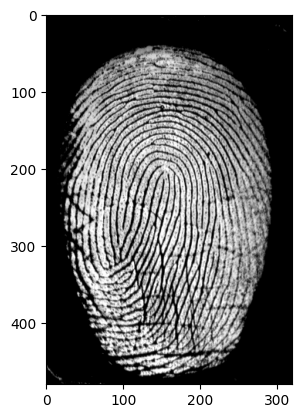

[INFO] Acquired fingerprint from file.
Image resolution: (480, 320, 3)


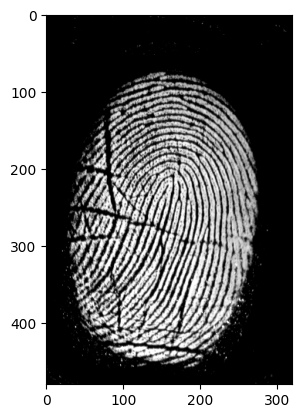

[INFO] Acquired fingerprint from file.
Image resolution: (480, 320, 3)


In [12]:
# tests the fingerprint acquisition
fingerprint_1 = acquire_from_file('/content/fulano_01.bmp', view=True)
print('Image resolution:', fingerprint_1.shape)

fingerprint_2 = acquire_from_file('/content/cicrano_01.bmp', view=True)
print('Image resolution:', fingerprint_2.shape)

--------------------------
## Fingerprint enhancement

In [13]:
# Enhances the given <fingerprint> image (numpy 2-D array with uint8 pixel
# values).
#
# Provide <dark-ridges> as False if the captured image is inverted
# (i.e., dark background and white ridges).
# Provide <view> as True if you want to see the results of computations.
#
# Returns a triple composed of: preprocessed fingerprint,
# skeletonized fingerprint, and fingerprint content mask.
def enhance(fingerprint, dark_ridges=True, view=False, output_height = 352):
    # resizes the fingerprint to present a height of <output_height> pixels,
    # keeping original aspect ratio
    aspect_ratio = float(fingerprint.shape[0]) / fingerprint.shape[1]
    width = int(round(output_height / aspect_ratio))
    fingerprint = cv2.resize(fingerprint, (width, output_height))

    # makes the fingerprint grayscale, if it is still colored
    if len(fingerprint.shape) > 2 and fingerprint.shape[2] > 1:  # more than one channel?
        fingerprint = cv2.cvtColor(fingerprint, cv2.COLOR_BGR2GRAY)

    # makes the fingerprint ridges dark, if this is the case
    if not dark_ridges:
        fingerprint = abs(255 - fingerprint)

    # shows the pre-processed fingerprint, if this is the case
    if view:
        plt.pyplot.imshow(fingerprint, cmap='gray')
        plt.pyplot.title('Original')
        plt.pyplot.show()

    # applies Gabor filters to the fingerprint with the third-party solution
    # described at https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python
    # the output is a binarized image
    fingerprint = gabor_applier().enhance(fingerprint)

    # shows the Gabor-filtered fingerprint, if this is the case
    if view:
        plt.pyplot.imshow(fingerprint, cmap='gray')
        plt.pyplot.title('Gabor filtered')
        plt.pyplot.show()

    # skeletonizes the fingerprint
    fingerprint = skimage.morphology.skeletonize(fingerprint)

    # shows the skeletonized fingerprint, if this is the case
    if view:
        plt.pyplot.imshow(fingerprint, cmap='gray')
        plt.pyplot.title('Skeletonized')
        plt.pyplot.show()

    # returns the enhanced fingerprint
    return fingerprint

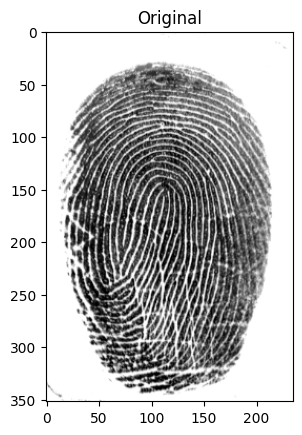

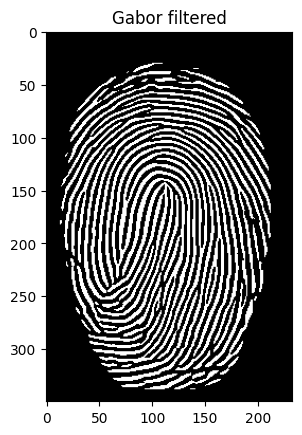

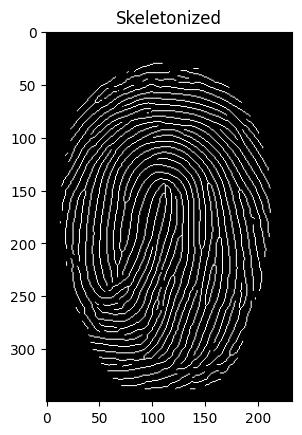

Enhanced fingerprint info; Size: (350, 233) Type: bool


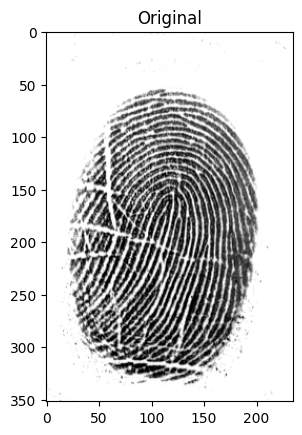

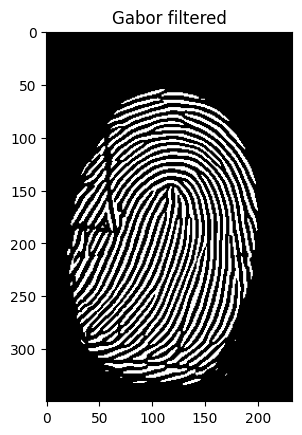

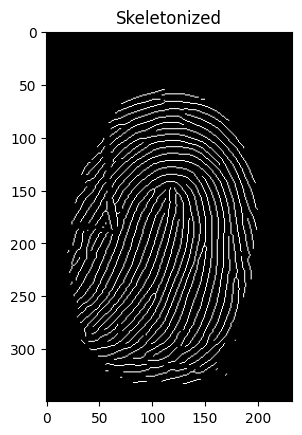

Enhanced fingerprint info; Size: (350, 233) Type: bool


In [14]:
# tests the fingerprint enhancement
enhanced_fp_1 = enhance(fingerprint_1, dark_ridges=False, view=True)
print('Enhanced fingerprint info; Size:', enhanced_fp_1.shape, 'Type:', enhanced_fp_1.dtype)

enhanced_fp_2 = enhance(fingerprint_2, dark_ridges=False, view=True)
print('Enhanced fingerprint info; Size:', enhanced_fp_2.shape, 'Type:', enhanced_fp_2.dtype)

--------------------------
## Fingerprint description

### Auxiliary functions
* <code>_draw_minutiae</code>: to draw the detected minutiae.
* <code>_sample_angle_patches</code>: to generate and sample patches with angles to detect over the minutiae.
* <code>_compute_minutiae_angle</code>: to compute the angle of a given minutiae.
* <code>_detect_minutiae</code>: to detect minutiae over a given fringerprint.
* <code>_remove_minutiae</code>: to remove the spurious minutiae.

In [15]:
# Draws, on the given <fingerprint> image, the given <ridge_endings> and
# <ridge_bifurcations> minutiae.
# Returns the fingerprint image with the drawn minutiae.
def _draw_minutiae(fingerprint, ridge_endings, ridge_bifurcations):
    # ridge angle magnitude representation size (in pixels).
    r_angle_mag = 5

    # ridge endings will be red squares,
    # while bifurcations will be green squares
    # the angle representation will be yellow
    r_color = (0, 0, 255)
    b_color = (0, 255, 0)
    a_color = (0, 255, 255)

    # prepares the output image
    img = fingerprint.astype(np.uint8)
    if img.max() == 1:
        img = fingerprint.astype(np.uint8) * 255
    if len(img.shape) < 3 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    for re in ridge_endings:
        p = (int(re[0]), int(re[1]))
        cv2.rectangle(img, (p[0] - 1, p[1] - 1), (p[0] + 2, p[1] + 2), r_color, 1)

        delta_x = int(round(np.cos(re[2]) * r_angle_mag))
        delta_y = int(round(np.sin(re[2]) * r_angle_mag))
        cv2.line(img, (p[0], p[1]), (p[0] + delta_x, p[1] + delta_y), a_color, 1)

    for bif in ridge_bifurcations:
        p = (int(bif[0]), int(bif[1]))
        cv2.rectangle(img, (p[0] - 1, p[1] - 1), (p[0] + 2, p[1] + 2), b_color, 1)

        delta_x = int(round(np.cos(bif[2]) * r_angle_mag))
        delta_y = int(round(np.sin(bif[2]) * r_angle_mag))
        cv2.line(img, (p[0], p[1]), (p[0] + delta_x, p[1] + delta_y), a_color, 1)

    return img

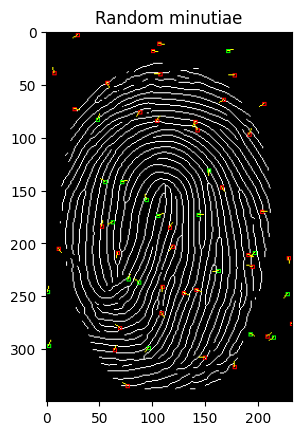

In [16]:
# tests drawing random minutiae on the given enhanced fingerprint
random_re = [list(re) for re in np.random.randint(1, 350, (50, 3))]
random_bif = [list(re) for re in np.random.randint(1, 350, (25, 3))]
minutiae_fp = _draw_minutiae(enhanced_fp_1, random_re, random_bif)
plt.pyplot.imshow(cv2.cvtColor(minutiae_fp, cv2.COLOR_BGR2RGB))
plt.pyplot.title('Random minutiae')
plt.pyplot.show()

In [17]:
# Generates and samples patches with angles to detect over the minutiae.
# Returns a list whose items are pairs with a patch and its respective angle.
def _sample_angle_patches(patch_size = 11):
  # patch center
  c = (patch_size // 2, patch_size // 2)

  # patch border points
  border_points = []
  for i in (0, patch_size - 1):
    for j in range(patch_size):
      border_points.append((i, j))
      if i != j:
        border_points.append((j, i))

  # creates the patches for each possible angle within the given patch size
  angle_samples = []
  for p in border_points:
    patch = np.zeros((patch_size, patch_size))
    cv2.line(patch, c, p, (255, 255, 255), 1)
    angle = np.arctan2(p[1] - c[1], p[0] - c[0])
    if angle < 0.0:
      angle = 2.0 * np.pi + angle
    angle_samples.append((patch > 0, angle))

  # returns the created patches with their respective angles
  return angle_samples

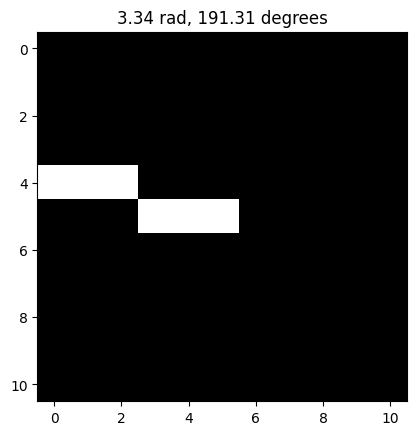

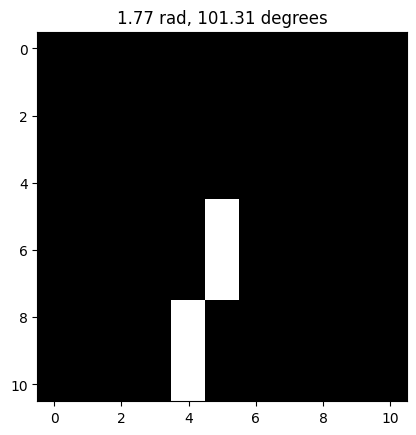

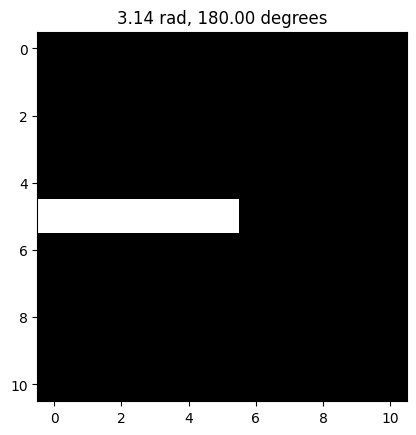

In [18]:
# tests the patch generation and randomly shows 3 of the dynamically created
# angle patches
import random

angle_samples = _sample_angle_patches()
for patch in random.sample(angle_samples, 3):
  plt.pyplot.imshow(patch[0], cmap='gray')
  plt.pyplot.title('{:.2f}'.format(patch[1]) + ' rad, ' + '{:.2f}'.format(patch[1] * 180 / np.pi) + ' degrees')
  plt.pyplot.show()

In [19]:
# Computes the angle of a given minutiae over a given <fingerprint>.
# The minutiae is expressed by its (x, y) position <pos>. The samples
# of angles <angle_samples> to try to match for must also be given.
# Provide <is_ridge_ending> as True if the minutiae is a ridge ending or
# False if it is a bifurcation.
# Returns the computed angle and the quality of the minutiae (the larger,
# the better).
def _compute_minutiae_angle(fingerprint, pos, angle_samples, is_ridge_ending):
  # output
  angle = None
  quality = None

  # gets the patch from the fingerprint whose center holds the minutiae
  offset = angle_samples[0][0].shape[0] // 2
  patch = fingerprint[pos[1] - offset:pos[1] + offset + 1,
                      pos[0] - offset:pos[0] + offset + 1]

  # fits the obtained patch with each angle patch sample
  fitting = []
  for p in angle_samples:
    fitting.append((np.sum(patch * p[0]), p[1]))
  fitting.sort(key=lambda x: x[0], reverse=True)

  # rindge ending? the angle is the best fit
  if is_ridge_ending:
    angle = fitting[0][1]
    quality = fitting[0][0]

  # else, we have a bifurcation
  else:
    # let's focus on the three best angle fitting
    # angle differences
    adiff_01 = abs(fitting[0][1] - fitting[1][1])
    if adiff_01 > np.pi:
      adiff_01 = 2.0 * np.pi - adiff_01

    adiff_02 = abs(fitting[0][1] - fitting[2][1])
    if adiff_02 > np.pi:
      adiff_02 = 2.0 * np.pi - adiff_02

    adiff_12 = abs(fitting[1][1] - fitting[2][1])
    if adiff_12 > np.pi:
      adiff_12 = 2.0 * np.pi - adiff_12

    # adiff_01 is the smallest difference...
    if adiff_01 < adiff_02 and adiff_01 < adiff_12:
      angle = fitting[0][1] + fitting[1][1] # sum of closest angles

    # adiff_02 is the smallest difference...
    elif adiff_02 < adiff_12:
      angle = fitting[0][1] + fitting[2][1] # sum of closest angles

    # adiff_12 is the smallest difference...
    else:
      angle = fitting[1][1] + fitting[2][1] # sum of closest angles

    # average of closest angles
    if angle > np.pi:
      angle = 2.0 * np.pi - angle
    angle = angle / 2.0

    # quality is the sum of the three best
    quality = fitting[0][0] + fitting[1][0] + fitting[2][0]

  return angle, quality

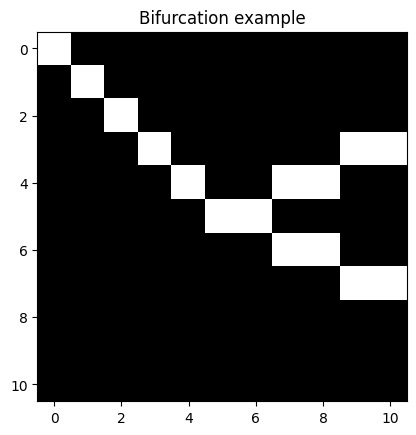

0.0 18


In [20]:
# tests the computation of the angle of the given minutiae
# all ridge endings...
for sample in angle_samples:
  angle, quality = _compute_minutiae_angle(sample[0], (5, 5), angle_samples, is_ridge_ending = True)
  assert angle == sample[1]

# bifurcation at 0 degree
patch = np.zeros((11, 11))
cv2.line(patch, (5, 5), (0, 0), (255, 255, 255), 1)
cv2.line(patch, (5, 5), (10, 3), (255, 255, 255), 1)
cv2.line(patch, (5, 5), (10, 7), (255, 255, 255), 1)
patch = patch > 0
plt.pyplot.imshow(patch, cmap='gray')
plt.pyplot.title('Bifurcation example')
plt.pyplot.show()

angle, quality = _compute_minutiae_angle(patch, (5, 5), angle_samples, is_ridge_ending = False)
assert angle == 0.0
print(angle, quality)

In [21]:
# Detects minutiae on the given <fingerprint> image, after proper enhancement.
# Provide <view> as True if you want to see the results of computations.
# Returns a list of ridge endings followed by a list of ridge bifurcations.
# Each element of these lists is a (x, y, angle, quality) minutiae description,
# where "x" and "y" define the position of the minutiae on the fingerprint,
# "angle" defines the angle of the involved ridges, in radians,
# and "quality" defines the quality of the minutiae (the larger,
# the better).
def _detect_minutiae(fingerprint, view=False):
    # outputs
    ridge_endings = []
    ridge_bifurcs = []

    # angle samples
    angle_samples = _sample_angle_patches()

    # fingerprint dimensions
    h, w = fingerprint.shape[:2]

    # for each ridge pixel
    for x in range(1, w - 1):
        for y in range(1, h - 1):
            # if the current pixel belongs to a ridge
            if fingerprint[y, x]:
                # current 3x3 block
                block = fingerprint[y - 1: y + 2, x - 1: x + 2]

                # number of ridge pixels in the neighborhood
                ridge_count = np.sum(block)

                # if the number of ridge pixels is bellow 3,
                # we may have a ridge ending
                if ridge_count < 3:
                    a, q = _compute_minutiae_angle(fingerprint, (x, y),
                                                   angle_samples,
                                                   is_ridge_ending = True)
                    ridge_endings.append((x, y, a, q))

                # else, if the number of ridge pixels is above 3,
                # we may have a bifurcation
                elif ridge_count > 3:
                    a, q = _compute_minutiae_angle(fingerprint, (x, y),
                                                   angle_samples,
                                                   is_ridge_ending=False)
                    ridge_bifurcs.append((x, y, a, q))

    # shows the detected minutiae, if it is the case
    if view:
      minutiae_fp = _draw_minutiae(fingerprint, ridge_endings, ridge_bifurcs)
      plt.pyplot.imshow(cv2.cvtColor(minutiae_fp, cv2.COLOR_BGR2RGB))
      plt.pyplot.title('All possible minutiae')
      plt.pyplot.show()

    return ridge_endings, ridge_bifurcs

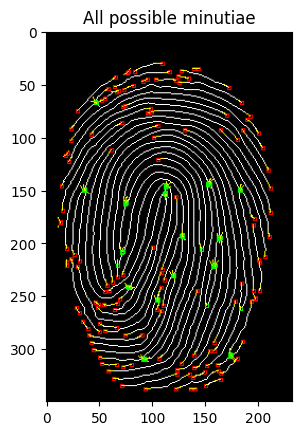

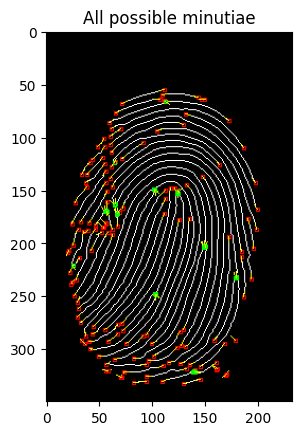

In [22]:
# tests the detection of minutiae
ridge_endings_1, bifurcations_1 = _detect_minutiae(enhanced_fp_1, view=True)
ridge_endings_2, bifurcations_2 = _detect_minutiae(enhanced_fp_2, view=True)

In [23]:
# Removes spurious minutiae detected on the given <fingerprint> image.
# Minutiae are provided through the <ridge_endings> and <ridge_bifurcations>
# parameters. Each one is a list of (x, y, angle, quality) items.
# Provide <view> as True if you want to see the results of computations.
# Returns a cleaned list of <ridge_endings> followed by a cleaned list of
# <ridge_bifurcations>.
def _remove_minutiae(fingerprint, ridge_endings, ridge_bifurcs, view=False,
                             min_minutiae_dist = 10, opp_angle_tol = np.pi / 16):
    # registers the minutiae that should be kept
    # (all good in the beginning)
    good_ridge_endings = [True] * len(ridge_endings)
    good_bifurcations = [True] * len(ridge_bifurcs)

    # here go the heuristics...
    # removes colliding minutiae, keeping only the ones with largest quality
    for i in range(0, len(ridge_endings) - 1):
        for j in range(i + 1, len(ridge_endings)):
            if good_ridge_endings[i] and good_ridge_endings[j]:
                if np.sqrt((ridge_endings[i][0] - ridge_endings[j][0]) ** 2 +
                 (ridge_endings[i][1] - ridge_endings[j][1]) ** 2) < 3:
                    if ridge_endings[i][3] > ridge_endings[j][3]:
                        good_ridge_endings[j] = False
                    elif ridge_endings[i][3] < ridge_endings[j][3]:
                        good_ridge_endings[i] = False

    for i in range(0, len(ridge_bifurcs) - 1):
        for j in range(i + 1, len(ridge_bifurcs)):
            if good_bifurcations[i] and good_bifurcations[j]:
                if np.sqrt((ridge_bifurcs[i][0] - ridge_bifurcs[j][0]) ** 2 +
                 (ridge_bifurcs[i][1] - ridge_bifurcs[j][1]) ** 2) < 3:
                    if ridge_bifurcs[i][3] > ridge_bifurcs[j][3]:
                        good_bifurcations[j] = False
                    elif ridge_bifurcs[i][3] < ridge_bifurcs[j][3]:
                        good_bifurcations[i] = False

    # removes ridge endings that are too close to the border of the fingerprint
    for i in range(len(ridge_endings)):
      if good_ridge_endings[i]:
        x, y = ridge_endings[i][0:2]
        h, w = fingerprint.shape[0:2]

        # searchs for ridge collisions up, down, left, and right
        collision_u = 0
        collision_d = 0
        collision_l = 0
        collision_r = 0
        no_collision = True

        # if any collision is zero, removes the ridge
        collision_u = np.sum(fingerprint[0:y, x])
        if collision_u > 0:
          collision_d = np.sum(fingerprint[y + 1:h, x])

        if collision_d > 0:
          collision_l = np.sum(fingerprint[y, 0:x])

        if collision_l > 0:
          collision_r = np.sum(fingerprint[y, x + 1:w])

        if collision_r > 0:
          no_collision = False

        if no_collision:
          good_ridge_endings[i] = False

    # removes ridge endings that are too close to each other and
    # have opposing angles (either small ridge or small gap)
    to_remove = []
    for i in range(0, len(ridge_endings) - 1):
        for j in range(i + 1, len(ridge_endings)):
            if good_ridge_endings[i] and good_ridge_endings[j]:
                if np.sqrt((ridge_endings[i][0] - ridge_endings[j][0]) ** 2 +
                 (ridge_endings[i][1] - ridge_endings[j][1]) ** 2) < min_minutiae_dist:
                 angle_diff = abs(ridge_endings[i][2] - ridge_endings[j][2])
                 if angle_diff > np.pi:
                     angle_diff = 2.0 * np.pi - angle_diff

                 if abs(np.pi - angle_diff) < opp_angle_tol:
                        to_remove.append(i)
                        to_remove.append(j)

    for i in to_remove:
        good_ridge_endings[i] = False

    # filters out spurious minutiae
    if len(ridge_endings) > 0:
        ridge_endings = np.array(ridge_endings)[np.where(good_ridge_endings)]
    else:
        ridge_endings = np.empty((0, 4))

    if len(ridge_bifurcs) > 0:
        ridge_bifurcs = np.array(ridge_bifurcs)[np.where(good_bifurcations)]
    else:
        ridge_bifurcs = np.empty((0, 4))

    # shows the minutiae, if it is the case
    if view:
      minutiae_fp = _draw_minutiae(fingerprint, ridge_endings, ridge_bifurcs)
      plt.pyplot.imshow(cv2.cvtColor(minutiae_fp, cv2.COLOR_BGR2RGB))
      plt.pyplot.title('No spurious minutiae')
      plt.pyplot.show()

    return ridge_endings, ridge_bifurcs

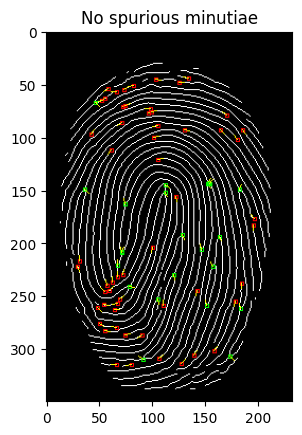

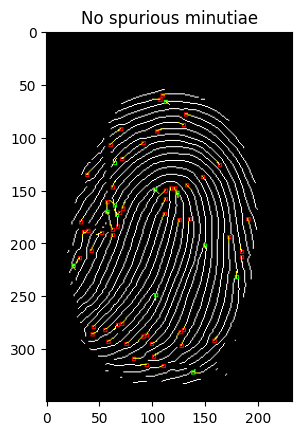

In [24]:
# tests the cleaning of spurious minutiae
ridge_endings_1, bifurcations_1 = _remove_minutiae(enhanced_fp_1,
                                                   ridge_endings_1,
                                                   bifurcations_1,
                                                   view=True)

ridge_endings_2, bifurcations_2 = _remove_minutiae(enhanced_fp_2,
                                                   ridge_endings_2,
                                                   bifurcations_2,
                                                   view=True)

### Main function

In [25]:
# Describes the given <enhanced_fingerprint> image through the
# detection and extraction of minutiae.
# Provide <view> as True if you want to see the results of computations.
# Returns a list of ridge endings followed by a list of ridge bifurcations.
# Each item of these lists is a (x, y, angle, quality) minutiae description.
def describe(fingerprint, view=False):
    # detects minutiae over the given fingerprint
    ridge_endings, bifurcations = _detect_minutiae(fingerprint, view=view)

    # removes non-essential minutiae, keeping only the "good" ones
    ridge_endings, bifurcations = _remove_minutiae(fingerprint,
                                                   ridge_endings, bifurcations,
                                                   view=view)

    # returns the obtained minutiae
    return ridge_endings, bifurcations

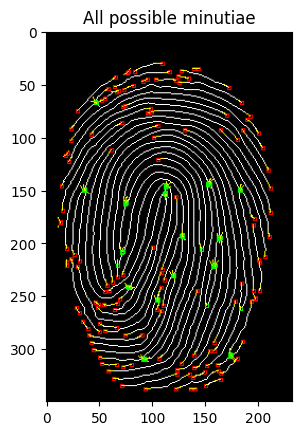

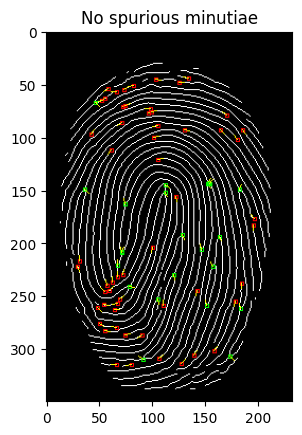

#ridge endings: 57
#bifurcations: 23


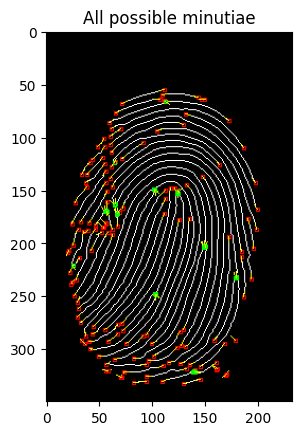

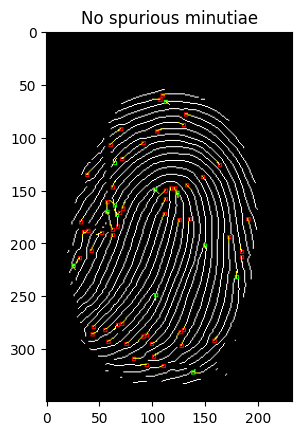

#ridge endings: 55
#bifurcations: 12


In [26]:
# tests a fingerprint description
ridge_endings_1, bifurcations_1 = describe(enhanced_fp_1, view=True)
print('#ridge endings:', len(ridge_endings_1))
print('#bifurcations:', len(bifurcations_1))

ridge_endings_2, bifurcations_2 = describe(enhanced_fp_2, view=True)
print('#ridge endings:', len(ridge_endings_2))
print('#bifurcations:', len(bifurcations_2))

-----------------------
## Fingerprint matching

### Auxiliary function
* <code>_draw_matches</code>: to draw the matches between two given fingerprints.
* <code>_compute_distance</code>: to compare two given minutiae, returning their distance in terms of how different they are.
* <code>_hough_translate</code>: to execute the translation step of the Hough transform at a given rotation angle and scale change.
* <code>_hough_transform</code>: to execute the full Hough transform.

In [27]:
# Draws the matching minutiae between the two fingerprint images
# <fingerprint_1> and <fingerprint_2>, according to the given <matches>
# minutiae index pairs.
# The involved minutiae are expressed by <ridge_endings_1> and <bifurcations_1>,
# belonging to <fingerprint_1>, and <ridge_endings_2> and <bifurcations_2>,
# belonging to <fingerprint_2>. No data is returned.
def _draw_matches(fingerprint_1, fingerprint_2, matches,
                  ridge_endings_1, bifurcations_1,
                  ridge_endings_2, bifurcations_2,
                  ridge_angle_mag = 5):
    # fingerprint dimensions
    h1, w1 = fingerprint_1.shape
    h2, w2 = fingerprint_2.shape

    # output_image with fingerprints side by side
    output_image = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
    output_image[0:h1, 0:w1] = (fingerprint_1 > 0).astype(np.uint8) * 255
    output_image[0:h2, w1:w1 + w2] = (fingerprint_2 > 0).astype(np.uint8) * 255
    output_image = cv2.cvtColor(output_image, cv2.COLOR_GRAY2BGR)

    # draws the matches
    # ridge endings
    for m in matches[0]:
        x0 = int(m[0][0])
        y0 = int(m[0][1])
        cv2.rectangle(output_image, (x0 - 1, y0 - 1), (x0 + 2, y0 + 2), (0, 0, 255), 1)
        delta_x = int(round(np.cos(m[0][2]) * ridge_angle_mag))
        delta_y = int(round(np.sin(m[0][2]) * ridge_angle_mag))
        cv2.line(output_image, (x0, y0), (x0 + delta_x, y0 + delta_y), (0, 255, 255), 1)

        x1 = int(m[1][0] + w1)
        y1 = int(m[1][1])
        cv2.rectangle(output_image, (x1 - 1, y1 - 1), (x1 + 2, y1 + 2), (0, 0, 255), 1)
        delta_x = int(round(np.cos(m[1][2]) * ridge_angle_mag))
        delta_y = int(round(np.sin(m[1][2]) * ridge_angle_mag))
        cv2.line(output_image, (x1, y1), (x1 + delta_x, y1 + delta_y), (0, 255, 255), 1)

        cv2.line(output_image, (x0, y0), (x1, y1), (0, 255, 255), 1)

    # bifurcations
    for m in matches[1]:
        x0 = int(m[0][0])
        y0 = int(m[0][1])
        cv2.rectangle(output_image, (x0 - 1, y0 - 1), (x0 + 2, y0 + 2), (0, 255, 0), 1)
        delta_x = int(round(np.cos(m[0][2]) * ridge_angle_mag))
        delta_y = int(round(np.sin(m[0][2]) * ridge_angle_mag))
        cv2.line(output_image, (x0, y0), (x0 + delta_x, y0 + delta_y), (0, 255, 255), 1)

        x1 = int(m[1][0] + w1)
        y1 = int(m[1][1])
        cv2.rectangle(output_image, (x1 - 1, y1 - 1), (x1 + 2, y1 + 2), (0, 255, 0), 1)
        delta_x = int(round(np.cos(m[1][2]) * ridge_angle_mag))
        delta_y = int(round(np.sin(m[1][2]) * ridge_angle_mag))
        cv2.line(output_image, (x1, y1), (x1 + delta_x, y1 + delta_y), (0, 255, 255), 1)

        cv2.line(output_image, (x0, y0), (x1, y1), (0, 255, 255), 1)

    # shows the resulting image
    plt.pyplot.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.pyplot.title('Matches')
    plt.pyplot.show()

In [28]:
# Compares the two given minutiae, returning their distance, in terms of how
# dissimilar they are.
def _compute_distance(minutiae_1, minutiae_2,
                      dist_trsh = 15, angle_trsh = np.pi / 9.0):
    # output
    output = float('inf') # default: two minutiae are too distant

    # computes the distance between the two minutiae and verify if they agree
    dist = np.sqrt((minutiae_1[0] - minutiae_2[0]) ** 2 + (minutiae_1[1] - minutiae_2[1]) ** 2)

    # computes the angle difference between the two minutiae and verify if they agree
    if dist < dist_trsh:
      angle_diff = abs(minutiae_1[2] - minutiae_2[2])
      if angle_diff > np.pi:
        angle_diff = 2.0 * np.pi - angle_diff

      if angle_diff < angle_trsh:
        output = (dist / dist_trsh + angle_diff / angle_trsh) / 2.0

    return output

In [ ]:
# tests the comparison of 2 minutiae
m1 = (0, 0, 0, 5)
m2 = (0, 30, 0, 5)
c = _compute_distance(m1, m2)
assert c == float('inf')

m1 = (0, 0, 0, 5)
m2 = (0, 5, 3.14, 5)
c = _compute_distance(m1, m2)
assert c == float('inf')

m1 = (0, 0, 0, 5)
m2 = (0, 5, 0.01, 5)
c = _compute_distance(m1, m2)
assert c < float('inf')
print('Distance:', c)

In [30]:
# Computes the matches between the given <minutiae_1_points>,
# <minutiae_1_angles>, <minutiae_1_types> elements belonging to "fingerprint 1",
# and the given <minutiae_2_points>, <minutiae_2_angles>, <minutiae_2_types>
# elements belonging to "fingerprint 2".
#
# Parameters <x_scale>, <y_scale>, and <rotation> angle express the
# transformation to be applied on top of the elements belonging to
# "fingerprint 2" before doing the match (Hough transform step).
#
# Returns a list of matches, whose elements are (i, j) pairs, with "i" defining
# the index of the matched minutiae within "fingerprint 1", and "j" defining
# the index of the matched minutiae within "fingerprint 2".
def _hough_translate(minutiae_1_points, minutiae_1_angles, minutiae_1_types,
                     minutiae_2_points, minutiae_2_angles, minutiae_2_types,
                     x_scale, y_scale, rotation,
                     hough_transl_overlay_rate = 0.25,
                     hough_transl_step = 10):
    # scales the second set of minutiae according to <x_scale> and <y_scale>
    scale_matrix = np.zeros((3, 3), dtype=np.float32)
    scale_matrix[0, 0] = x_scale
    scale_matrix[1, 1] = y_scale
    scale_matrix[2, 2] = 1.0
    minutiae_2_points = cv2.perspectiveTransform(
        np.float32([minutiae_2_points]), scale_matrix)[0]

    # rotates the second set of minutiae according to <rotation>
    sine = np.sin(rotation)
    cosine = np.cos(rotation)

    rotation_matrix = np.zeros((3, 3))
    rotation_matrix[0, 0] = cosine
    rotation_matrix[0, 1] = -sine
    rotation_matrix[1, 0] = sine
    rotation_matrix[1, 1] = cosine
    rotation_matrix[2, 2] = 1.0
    minutiae_2_points = cv2.perspectiveTransform(
        np.float32([minutiae_2_points]), rotation_matrix)[0]

    # updates the angles of the second set of minutiae according to the
    # applied rotation
    minutiae_2_angles = minutiae_2_angles.copy()
    for i in range(len(minutiae_2_angles)):
        angle = minutiae_2_angles[i]

        new_angle = angle + rotation
        if new_angle > np.pi:
            new_angle = new_angle - 2.0 * np.pi

        minutiae_2_angles[i] = new_angle

    # makes the sets of minutiae be as close to their respective (x,y) axes as possible
    minutiae_1_points = minutiae_1_points - [np.min(minutiae_1_points[:, 0]), np.min(minutiae_1_points[:, 1])]
    minutiae_2_points = minutiae_2_points - [np.max(minutiae_2_points[:, 0]), np.max(minutiae_2_points[:, 1])]

    # computes the variables to control minutiae translations
    minutiae_1_corner_1 = np.array([np.min(minutiae_1_points[:, 0]),
                                    np.min(minutiae_1_points[:, 1])], dtype=int)
    minutiae_1_corner_2 = np.array([np.max(minutiae_1_points[:, 0]),
                                    np.max(minutiae_1_points[:, 1])], dtype=int)

    minutiae_1_w, minutiae_1_h = minutiae_1_corner_2 - minutiae_1_corner_1
    minutiae_1_x_offset = int(round((1.0 - hough_transl_overlay_rate) * minutiae_1_w / 2.0))
    minutiae_1_y_offset = int(round((1.0 - hough_transl_overlay_rate) * minutiae_1_h / 2.0))

    minutiae_2_corner_1 = np.array([np.min(minutiae_2_points[:, 0]),
                                    np.min(minutiae_2_points[:, 1])], dtype=int)
    minutiae_2_corner_2 = np.array([np.max(minutiae_2_points[:, 0]),
                                    np.max(minutiae_2_points[:, 1])], dtype=int)

    minutiae_2_w, minutiae_2_h = minutiae_2_corner_2 - minutiae_2_corner_1
    minutiae_2_x_offset = int(round((1.0 - hough_transl_overlay_rate) * minutiae_2_w / 2.0))
    minutiae_2_y_offset = int(round((1.0 - hough_transl_overlay_rate) * minutiae_2_h / 2.0))

    start_x = minutiae_1_x_offset + minutiae_2_x_offset
    stop_x = start_x + minutiae_1_w + minutiae_2_w - minutiae_1_x_offset - minutiae_2_x_offset
    start_y = minutiae_1_y_offset + minutiae_2_y_offset
    stop_y = start_y + minutiae_1_h + minutiae_2_h - minutiae_1_y_offset - minutiae_2_y_offset

    # stores the best matches found so far
    best_matches = []

    # for each interesting translation of the second set of minutiae
    for x_translation in range(start_x, stop_x, hough_transl_step):
        for y_translation in range(start_y, stop_y, hough_transl_step):
            # applies the current translation
            minutiae_2_points_transl = minutiae_2_points + [x_translation, y_translation]

            # computes the current matches
            matches = []
            already_matched = []
            for i in range(minutiae_1_points.shape[0]):
                current_match = None
                current_match_dist = float('inf')

                for j in range(minutiae_2_points_transl.shape[0]):
                    if j not in already_matched and minutiae_1_types[i] == minutiae_2_types[j] and \
                            minutiae_2_points_transl[j][0] > 0.0 and minutiae_2_points_transl[j][1] > 0.0:
                        dist = _compute_distance((minutiae_1_points[i][0], minutiae_1_points[i][1], minutiae_1_angles[i]),
                         (minutiae_2_points_transl[j][0], minutiae_2_points_transl[j][1], minutiae_2_angles[j]))
                        if dist < current_match_dist:
                            current_match = j
                            current_match_dist = dist

                if current_match is not None:
                    matches.append((i, current_match))
                    already_matched.append(current_match)

            # if the number of matches is larger than the one found before,
            # registers the current matches as the best ones
            if len(best_matches) < len(matches):
                best_matches = matches

    # returns the best set of matches
    return best_matches

In [31]:
# import multiprocessing

# Applies Hough transform to simultaneously match <ridge_endings_1> to <ridge_endings_2>,
# and <ridge_bifurcations_1> to <ridge_bifurcations_2>.
# Returns two lists of matches, one for ridge endings, and the other for ridge bifurcations.
# The elements of these lists are (minutiae_1, minutiae_2) pairs, where each minutiae is represented by
# a (x, y, angle) triple; "x" and "y" define the pixel position of the minutiae on its respective fingerprint image,
# and "angle" define the minutiae orientation in radians.
def _hough_transform(ridge_endings_1, ridge_bifurcations_1,
                     ridge_endings_2, ridge_bifurcations_2,
                     hough_scale_range = [1.0],
                     hough_rotation_range = np.arange(-np.pi / 4.0, np.pi / 4.0 + 0.1, np.pi/8.0)):
    # data preparation for performing the Hough transform
    if len(ridge_endings_1) > 0 and len(ridge_bifurcations_1) > 0:
        minutiae_set_1 = np.concatenate((ridge_endings_1, ridge_bifurcations_1), axis=0)
    elif len(ridge_endings_1) > 0:
        minutiae_set_1 = ridge_endings_1
    elif len(ridge_bifurcations_1) > 0:
        minutiae_set_1 = ridge_bifurcations_1
    else:
        minutiae_set_1 = []

    if len(ridge_endings_2) > 0 and len(ridge_bifurcations_2) > 0:
        minutiae_set_2 = np.concatenate((ridge_endings_2, ridge_bifurcations_2), axis=0)
    elif len(ridge_endings_2) > 0:
        minutiae_set_2 = ridge_endings_2
    elif len(ridge_bifurcations_2) > 0:
        minutiae_set_2 = ridge_bifurcations_2
    else:
        minutiae_set_2 = []

    if len(minutiae_set_1) == 0 or len(minutiae_set_2) == 0:
        return [], []

    minutiae_1_points = np.array([[minutiae_set_1[0][0], minutiae_set_1[0][1]]])
    minutiae_1_angles = [minutiae_set_1[0][2]]
    minutiae_1_types = [True] * len(ridge_endings_1) + [False] * len(ridge_bifurcations_1)
    for i in range(1, len(minutiae_set_1)):
        minutiae_1_points = np.append(minutiae_1_points, [[minutiae_set_1[i][0], minutiae_set_1[i][1]]], 0)
        minutiae_1_angles.append(minutiae_set_1[i][2])

    minutiae_2_points = np.array([[minutiae_set_2[0][0], minutiae_set_2[0][1]]])
    minutiae_2_angles = [minutiae_set_2[0][2]]
    minutiae_2_types = [True] * len(ridge_endings_2) + [False] * len(ridge_bifurcations_2)
    for i in range(1, len(minutiae_set_2)):
        minutiae_2_points = np.append(minutiae_2_points, [[minutiae_set_2[i][0], minutiae_set_2[i][1]]], 0)
        minutiae_2_angles.append(minutiae_set_2[i][2])

    # holds the best matches found so far
    best_matches = []
    best_config = None

    # for each Hough configuration...
    # # multiprocessing in action
    # pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    # pool_result = [pool.apply_async(_hough_translate,
    #                                 args=(minutiae_1_points, minutiae_1_angles, minutiae_1_types,
    #                                       minutiae_2_points, minutiae_2_angles, minutiae_2_types,
    #                                       x_scale, y_scale, rotation))
    #                for x_scale in hough_scale_range
    #                for y_scale in hough_scale_range
    #                for rotation in hough_rotation_range]
    # results = [r.get() for r in pool_result]
    # pool.close()

    # i = -1
    # for x_scale in hough_scale_range:
    #     for y_scale in hough_scale_range:
    #         for rotation in hough_rotation_range:
    #             i = i + 1
    #             print('[INFO] Hough transform at', str([x_scale, y_scale, rotation]) + ':',
    #                   len(results[i]), 'matches.')
    #             if len(best_matches) < len(results[i]):
    #                 best_matches = results[i]
    #                 best_config = [x_scale, y_scale, rotation]
    # # end of multiprocessing

    # if you get a "freeze support" runtime error when running this solution, please comment the multiprocessing
    # code block above and replace it with the following commented "for" block...
    for x_scale in hough_scale_range:
       for y_scale in hough_scale_range:
           for rotation in hough_rotation_range:
               results = _hough_translate(minutiae_1_points, minutiae_1_angles, minutiae_1_types,
                                          minutiae_2_points, minutiae_2_angles, minutiae_2_types,
                                          x_scale, y_scale, rotation)

               print('[INFO] Hough transform at', str([x_scale, y_scale, rotation]) + ':',
                     len(results), 'matches.')

               if len(best_matches) < len(results):
                   best_matches = results
                   best_config = [x_scale, y_scale, rotation]
    # end of non-multiprocessing solution

    # found the best matches up here
    print('[INFO] Best Hough with:', len(best_matches), 'matches, at:', str(best_config) + '.')

    # returns the matches separated in ridge endings and bifurcations
    ridge_ending_matches = []
    bifurcation_matches = []
    for m in best_matches:
        if minutiae_1_types[m[0]]:
            ridge_ending_matches.append(((minutiae_set_1[m[0]][0], minutiae_set_1[m[0]][1], minutiae_1_angles[m[0]]),
                                         (minutiae_set_2[m[1]][0], minutiae_set_2[m[1]][1], minutiae_2_angles[m[1]])))

        else:
            bifurcation_matches.append(((minutiae_set_1[m[0]][0], minutiae_set_1[m[0]][1], minutiae_1_angles[m[0]]),
                                        (minutiae_set_2[m[1]][0], minutiae_set_2[m[1]][1], minutiae_2_angles[m[1]])))

    return ridge_ending_matches, bifurcation_matches

### Main function

In [32]:
# Matches the given <ridge_endings_1> (belonging to <fingerprint_1> image) to the given <ridge_endings_2>
# (belonging to <fingerprint_2> image). Does the same for <ridge_bifurcations_1> and <ridge_bifurcations_2>.
# Provide <view> as True if you want to see the results of computations.
#
# Returns two lists of matches, one for ridge endings, and the other for ridge bifurcations.
# The elements of these lists are (minutiae_1, minutiae_2) pairs, where each minutiae is represented by
# a (x, y, angle) triple; "x" and "y" define the pixel position of the minutiae on its respective fingerprint image,
# and "angle" define the minutiae orientation in radians.
#
# Also returns the computed match score.
def match(fingerprint_1, ridge_endings_1, bifurcations_1,
          fingerprint_2, ridge_endings_2, bifurcations_2,
          view=False):
    # performs Hough transforms to find the best set of matches
    matches = _hough_transform(ridge_endings_1, bifurcations_1,
                               ridge_endings_2, bifurcations_2)

    # draws the best matches, if it is the case
    if view:
        _draw_matches(fingerprint_1, fingerprint_2, matches,
                      ridge_endings_1, bifurcations_1,
                      ridge_endings_2, bifurcations_2)

    # returns the best matches
    return matches

[INFO] Acquired fingerprint from file.
[INFO] Acquired fingerprint from file.
[INFO] Hough transform at [1.0, 1.0, np.float64(-0.7853981633974483)]: 15 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(-0.39269908169872414)]: 21 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.0)]: 95 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.39269908169872414)]: 20 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.7853981633974483)]: 12 matches.
[INFO] Best Hough with: 95 matches, at: [1.0, 1.0, np.float64(0.0)].


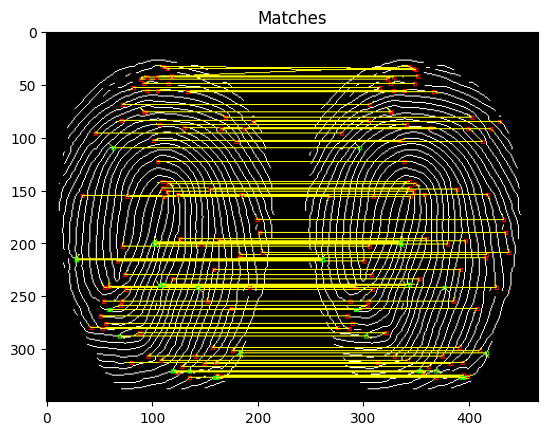

#Matches: 95


In [33]:
# tests the matching function
# exact same fingerprint capture
fingerprint_1 = acquire_from_file('/content/fulano_01.bmp')
fingerprint_2 = acquire_from_file('/content/fulano_01.bmp')

enhanced_fp_1 = enhance(fingerprint_1)
enhanced_fp_2 = enhance(fingerprint_2)

ridge_endings_1, bifurcations_1 = describe(enhanced_fp_1)
ridge_endings_2, bifurcations_2 = describe(enhanced_fp_2)

matches = match(
    enhanced_fp_1, ridge_endings_1, bifurcations_1,
    enhanced_fp_2, ridge_endings_2, bifurcations_2,
    view=True)

print('#Matches:', len(matches[0]) + len(matches[1]))

[INFO] Acquired fingerprint from file.
[INFO] Acquired fingerprint from file.
[INFO] Hough transform at [1.0, 1.0, np.float64(-0.7853981633974483)]: 16 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(-0.39269908169872414)]: 24 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.0)]: 48 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.39269908169872414)]: 20 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.7853981633974483)]: 13 matches.
[INFO] Best Hough with: 48 matches, at: [1.0, 1.0, np.float64(0.0)].


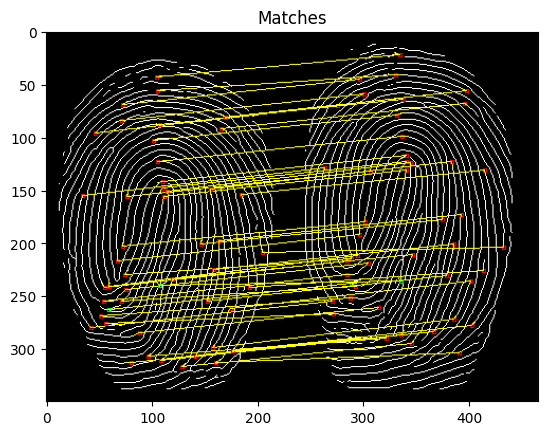

#Matches: 48


In [34]:
# same fingerprint but different captures
fingerprint_1 = acquire_from_file('/content/fulano_01.bmp')
fingerprint_2 = acquire_from_file('/content/fulano_02.bmp')

enhanced_fp_1 = enhance(fingerprint_1)
enhanced_fp_2 = enhance(fingerprint_2)

ridge_endings_1, bifurcations_1 = describe(enhanced_fp_1)
ridge_endings_2, bifurcations_2 = describe(enhanced_fp_2)

matches = match(
    enhanced_fp_1, ridge_endings_1, bifurcations_1,
    enhanced_fp_2, ridge_endings_2, bifurcations_2,
    view=True)

print('#Matches:', len(matches[0]) + len(matches[1]))

[INFO] Acquired fingerprint from file.
[INFO] Acquired fingerprint from file.
[INFO] Hough transform at [1.0, 1.0, np.float64(-0.7853981633974483)]: 15 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(-0.39269908169872414)]: 23 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.0)]: 45 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.39269908169872414)]: 18 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.7853981633974483)]: 12 matches.
[INFO] Best Hough with: 45 matches, at: [1.0, 1.0, np.float64(0.0)].


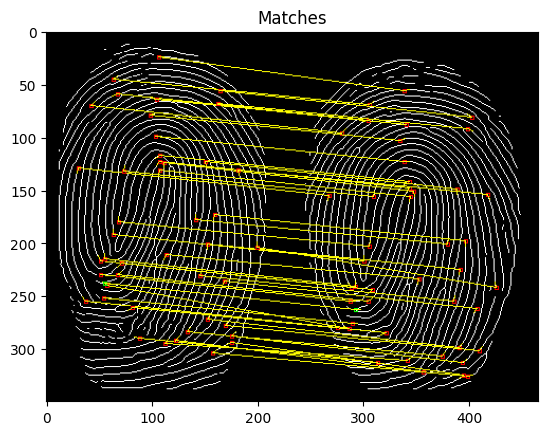

#Matches: 45


In [35]:
# same fingerprint but different captures
fingerprint_1 = acquire_from_file('/content/fulano_02.bmp')
fingerprint_2 = acquire_from_file('/content/fulano_01.bmp')

enhanced_fp_1 = enhance(fingerprint_1)
enhanced_fp_2 = enhance(fingerprint_2)

ridge_endings_1, bifurcations_1 = describe(enhanced_fp_1)
ridge_endings_2, bifurcations_2 = describe(enhanced_fp_2)

matches = match(
    enhanced_fp_1, ridge_endings_1, bifurcations_1,
    enhanced_fp_2, ridge_endings_2, bifurcations_2,
    view=True)

print('#Matches:', len(matches[0]) + len(matches[1]))

[INFO] Acquired fingerprint from file.
[INFO] Acquired fingerprint from file.
[INFO] Hough transform at [1.0, 1.0, np.float64(-0.7853981633974483)]: 16 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(-0.39269908169872414)]: 23 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.0)]: 43 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.39269908169872414)]: 18 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.7853981633974483)]: 11 matches.
[INFO] Best Hough with: 43 matches, at: [1.0, 1.0, np.float64(0.0)].


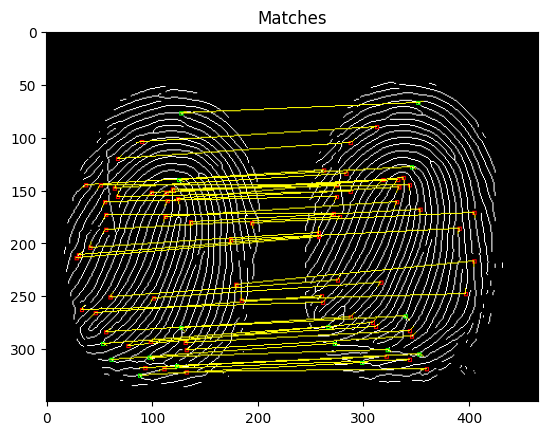

#Matches: 43


In [36]:
# same fingerprint but different captures
fingerprint_1 = acquire_from_file('/content/cicrano_01.bmp')
fingerprint_2 = acquire_from_file('/content/cicrano_02.bmp')

enhanced_fp_1 = enhance(fingerprint_1)
enhanced_fp_2 = enhance(fingerprint_2)

ridge_endings_1, bifurcations_1 = describe(enhanced_fp_1)
ridge_endings_2, bifurcations_2 = describe(enhanced_fp_2)

matches = match(
    enhanced_fp_1, ridge_endings_1, bifurcations_1,
    enhanced_fp_2, ridge_endings_2, bifurcations_2,
    view=True)

print('#Matches:', len(matches[0]) + len(matches[1]))

[INFO] Acquired fingerprint from file.
[INFO] Acquired fingerprint from file.
[INFO] Hough transform at [1.0, 1.0, np.float64(-0.7853981633974483)]: 12 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(-0.39269908169872414)]: 17 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.0)]: 20 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.39269908169872414)]: 14 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.7853981633974483)]: 11 matches.
[INFO] Best Hough with: 20 matches, at: [1.0, 1.0, np.float64(0.0)].


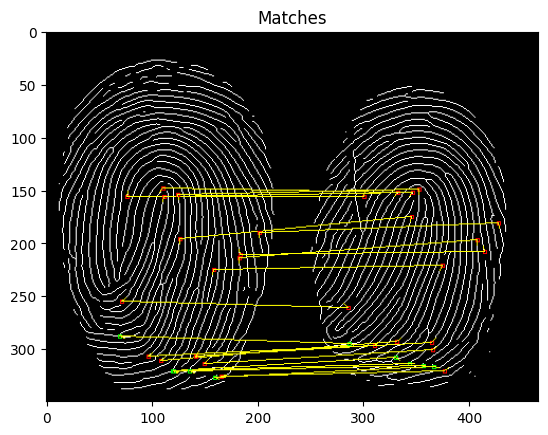

#Matches: 20


In [37]:
# different fingerprints
fingerprint_1 = acquire_from_file('/content/fulano_01.bmp')
fingerprint_2 = acquire_from_file('/content/cicrano_01.bmp')

enhanced_fp_1 = enhance(fingerprint_1)
enhanced_fp_2 = enhance(fingerprint_2)

ridge_endings_1, bifurcations_1 = describe(enhanced_fp_1)
ridge_endings_2, bifurcations_2 = describe(enhanced_fp_2)

matches = match(
    enhanced_fp_1, ridge_endings_1, bifurcations_1,
    enhanced_fp_2, ridge_endings_2, bifurcations_2,
    view=True)

print('#Matches:', len(matches[0]) + len(matches[1]))

[INFO] Acquired fingerprint from file.
[INFO] Acquired fingerprint from file.
[INFO] Hough transform at [1.0, 1.0, np.float64(-0.7853981633974483)]: 19 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(-0.39269908169872414)]: 20 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.0)]: 20 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.39269908169872414)]: 17 matches.
[INFO] Hough transform at [1.0, 1.0, np.float64(0.7853981633974483)]: 13 matches.
[INFO] Best Hough with: 20 matches, at: [1.0, 1.0, np.float64(-0.39269908169872414)].


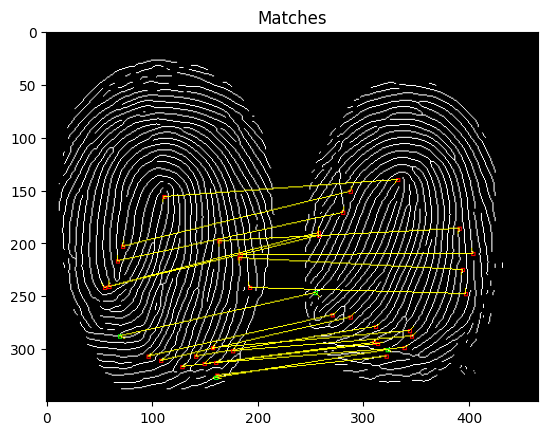

#Matches: 20


In [38]:
# different fingerprints
fingerprint_1 = acquire_from_file('/content/fulano_01.bmp')
fingerprint_2 = acquire_from_file('/content/cicrano_02.bmp')

enhanced_fp_1 = enhance(fingerprint_1)
enhanced_fp_2 = enhance(fingerprint_2)

ridge_endings_1, bifurcations_1 = describe(enhanced_fp_1)
ridge_endings_2, bifurcations_2 = describe(enhanced_fp_2)

matches = match(
    enhanced_fp_1, ridge_endings_1, bifurcations_1,
    enhanced_fp_2, ridge_endings_2, bifurcations_2,
    view=True)

print('#Matches:', len(matches[0]) + len(matches[1]))

---
## Exercise
Implement a decision function that leverages the simple score presented in class.   
> ${sim\_score} = \frac{\#\text{matches}}{(\#\text{minutiae}_i \ + \  \#\text{minutiae}_j) \ \times \ 0.5}$

In [40]:
# add your implementation here
def calculate_similarity_score(matches, ridge_endings_1, bifurcations_1, ridge_endings_2, bifurcations_2):
    num_matches = len(matches[0]) + len(matches[1])
    total_minutiae_1 = len(ridge_endings_1) + len(bifurcations_1)
    total_minutiae_2 = len(ridge_endings_2) + len(bifurcations_2)

    denominator = (total_minutiae_1 + total_minutiae_2) * 0.5

    if denominator == 0:
        return 0.0 # Avoid division by zero if no minutiae are found

    sim_score = num_matches / denominator
    return sim_score

# Example usage with the last comparison:
score = calculate_similarity_score(matches, ridge_endings_1, bifurcations_1, ridge_endings_2, bifurcations_2)
print(f'Similarity Score: {score:.2f}')

Similarity Score: 0.21
